# Assignment 1 - CATCH

Sources: \
https://github.com/yxu1168/Reinforcement-Learning-DQN-for-ATARI-s-Pong-Game---TensorFlow-2.0-Keras/blob/master/Reinforcement_Learning_CNN_DQN_for_ATARI%E2%80%99s_Pong_Game.ipynb

https://github.com/PacktPublishing/Hands-on-Reinforcement-Learning-with-PyTorch/blob/master/Section%203/3.5%20DQN%20with%20Pong.ipynb

https://keras.io/examples/rl/deep_q_network_breakout/

## Libraries

In [10]:
import random
import datetime

import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize

from collections import deque

import tensorflow as tf
from tensorflow import keras

import pandas as pd

## Catch

In [2]:
class CatchEnv():
    def __init__(self):
        self.size = 21
        self.image = np.zeros((self.size, self.size))
        self.state = []
        self.fps = 4
        self.output_shape = (84, 84)

    def reset_random(self):
        self.image.fill(0)
        self.pos = np.random.randint(2, self.size-2)
        self.vx = np.random.randint(5) - 2
        self.vy = 1
        self.ballx, self.bally = np.random.randint(self.size), 4
        self.image[self.bally, self.ballx] = 1
        self.image[-5, self.pos - 2:self.pos + 3] = np.ones(5)

        return self.step(2)[0]

    def step(self, action):
        def left():
            if self.pos > 3:
                self.pos -= 2
        def right():
            if self.pos < 17:
                self.pos += 2
        def noop():
            pass
        {0: left, 1: right, 2: noop}[action]()

        self.image[self.bally, self.ballx] = 0
        self.ballx += self.vx
        self.bally += self.vy
        if self.ballx > self.size - 1:
            self.ballx -= 2 * (self.ballx - (self.size-1))
            self.vx *= -1
        elif self.ballx < 0:
            self.ballx += 2 * (0 - self.ballx)
            self.vx *= -1
        self.image[self.bally, self.ballx] = 1

        self.image[-5].fill(0)
        self.image[-5, self.pos-2:self.pos+3] = np.ones(5)
    
        terminal = self.bally == self.size - 1 - 4
        reward = int(self.pos - 2 <= self.ballx <= self.pos + 2) if terminal else 0

        [self.state.append(resize(self.image, (84, 84))) for _ in range(self.fps - len(self.state) + 1)]
        self.state = self.state[-self.fps:]

        return np.transpose(self.state, [1, 2, 0]), reward, terminal

    def get_num_actions(self):
        return 3

    def reset(self):
        return self.reset_random()

    def state_shape(self):
        return (self.fps,) + self.output_shape

## Experience Replay Buffer

In [4]:
class ReplayBuffer():
    def __init__(self):
        self.buffer = deque()# queue of trajectories. Newest trajectories are appended to tthe beginning
        self.max_size = 1e6 # maximum number of trajectories to store
    
    def add(self, data):
        if len(self.buffer) == self.max_size:
            self.buffer.pop()
            self.buffer.appendleft(data)
        else:
            self.buffer.appendleft(data)

    def sample(self, batch_size):
        indices = np.random.randint(len(self.buffer), size=batch_size)
        states, actions, rewards, states_next, terminals = [], [], [], [], []

        for i in indices:
            s, a, r, sn, t = self.buffer[i]
            states.append(s)
            actions.append(a)
            rewards.append(r)
            states_next.append(sn)
            terminals.append(t)
            
        return np.array(states), np.array(actions), np.array(rewards), np.array(states_next), np.array(terminals)

## Deep Q Network

In [5]:
input_shape = (84, 84, 4)
num_actions = 3

def DQN_Model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size = 8, strides = 4, activation='relu', input_shape=input_shape),
        tf.keras.layers.Conv2D(64, kernel_size = 4, strides = 2, activation='relu'),
        tf.keras.layers.Conv2D(64, kernel_size = 3, strides = 1, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(num_actions, activation="linear")
    ])
    
    return model

## Hyperparameters
Loads the hyperparameters for the agent and the environment from a csv file

In [33]:
hyper_params = pd.read_excel("hyperparameters.xlsx")

## Agent

In [34]:
optimizer = keras.optimizers.RMSprop(learning_rate=float(hyper_params["learning_rate"]), clipnorm=1.0)
loss_fn = keras.losses.mse

class Agent():
    def __init__(self):
        self.action_size = num_actions
        self.train_net = DQN_Model()
        self.target_net = DQN_Model()
        
        # hyperparameters
        self.batch_size = int(hyper_params["batch_size"])
        self.epsilon = float(hyper_params["epsilon"])
        self.epsilon_end = float(hyper_params["epsilon_end"])
        self.epsilon_decay = float(hyper_params["epsilon_decay"])
        self.gamma = float(hyper_params["gamma"])

    # select an action based on epsilon greedy method
    def action(self, state, evaluate):
        if np.random.rand() < self.epsilon and not evaluate:
            return random.randint(0, 2)
        else:
            return np.argmax(self.train_net(state))

    # decay epsilon
    def decay_epsilon(self):
        if self.epsilon > self.epsilon_end:
            self.epsilon -= self.epsilon_decay

    # train the model
    def train(self, replay_buffer):

        # sample from the experience replay buffer
        states, actions, rewards, states_next, terminals = replay_buffer.sample(self.batch_size)
        mask = tf.one_hot(actions, self.action_size) # used to format train_q into (32, 1) just like target_Q

        # GradientTape is a more customizable version of .fit()
        with tf.GradientTape() as tape:
            train_q = self.train_net(states)
            train_q = tf.reduce_sum(train_q * mask, axis=1)
            
            target_q = rewards + (1 - terminals) * self.gamma * tf.reduce_max(self.target_net(states_next), axis=1)
            
            loss = loss_fn(target_q, train_q)

        gradients = tape.gradient(loss, self.train_net.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.train_net.trainable_variables))

        return loss

    # update the target network by copying the weights from the train_network
    def update_target_network(self):
        self.target_net.set_weights(self.train_net.get_weights())

## Main Loop

In [35]:
def run_environment():
    env = CatchEnv()
    agent = Agent()
    replay_buffer = ReplayBuffer()

    # hyperparameters
    n_episodes = int(hyper_params["n_episodes"]) # total number of episodes to run the environment
    n_evaluate = int(hyper_params["n_evaluate"]) # number of episodes for training/evaluating alternatively
    n_update = int(hyper_params["n_update"]) # number of training episodes after which the target network is updated
    
    cnt_evaluate = n_evaluate; cnt_update = n_update
    evaluate = False
    
    # trackers
    reward_tracker = []
    loss_tracker = []

    for episode in range(n_episodes):

        state = env.reset()
        terminal = False
        
        while not terminal:
            
            # agent takes an action
            action = agent.action(np.reshape(state, (1, 84, 84, 4)), evaluate)

            # generate the next frame based on the agent action
            state_next, reward, terminal = env.step(action)

            # add experience to replay buffer
            replay_buffer.add((state, action, reward, state_next, terminal))

            # update the current state
            state = state_next
            
        # train the agent
        if not evaluate:
            loss = agent.train(replay_buffer)
            loss_tracker.append(loss.numpy())
            
            # update the target network after n_update
            cnt_update -= 1
            if cnt_update == 0:
                cnt_update = n_update
                agent.update_target_network()

        # decay epsilon
        agent.decay_epsilon()
                
        cnt_evaluate -= 1
        if cnt_evaluate == 0:
            cnt_evaluate = n_evaluate
            evaluate = not evaluate

        # stats
        reward_tracker.append(reward)
        print("EPISODE: {} - Rewards: {} - Loss.avg(10):{:.5f} - Score.avg(10): {:.2f} - Evaluate: {}".format(episode,  
                                sum(reward_tracker), round(sum(loss_tracker[-10:])/10, 5), 
                                round(sum(reward_tracker[-10:])/10, 2), evaluate))

    return np.array(reward_tracker), np.array(loss_tracker)

# Run

In [36]:
rewards, loss = run_environment()

EPISODE: 0 - Rewards: 0 - Loss.avg(10):0.00017 - Score.avg(10): 0.00 - Evaluate: False
EPISODE: 1 - Rewards: 0 - Loss.avg(10):0.00074 - Score.avg(10): 0.00 - Evaluate: False
EPISODE: 2 - Rewards: 0 - Loss.avg(10):0.00083 - Score.avg(10): 0.00 - Evaluate: False
EPISODE: 3 - Rewards: 0 - Loss.avg(10):0.00086 - Score.avg(10): 0.00 - Evaluate: False
EPISODE: 4 - Rewards: 0 - Loss.avg(10):0.00088 - Score.avg(10): 0.00 - Evaluate: False
EPISODE: 5 - Rewards: 0 - Loss.avg(10):0.00092 - Score.avg(10): 0.00 - Evaluate: False
EPISODE: 6 - Rewards: 0 - Loss.avg(10):0.00099 - Score.avg(10): 0.00 - Evaluate: False
EPISODE: 7 - Rewards: 0 - Loss.avg(10):0.00100 - Score.avg(10): 0.00 - Evaluate: False
EPISODE: 8 - Rewards: 0 - Loss.avg(10):0.00102 - Score.avg(10): 0.00 - Evaluate: False
EPISODE: 9 - Rewards: 0 - Loss.avg(10):0.00102 - Score.avg(10): 0.00 - Evaluate: True
EPISODE: 10 - Rewards: 0 - Loss.avg(10):0.00102 - Score.avg(10): 0.00 - Evaluate: True
EPISODE: 11 - Rewards: 1 - Loss.avg(10):0.00

## Save Results

In [37]:
timestamp = datetime.datetime.now().strftime("%d_%H-%M-%S")

np.save('results/rewards_{}.npy'.format(timestamp), rewards)
np.save('results/loss_{}.npy'.format(timestamp), loss)

## Inspect Results

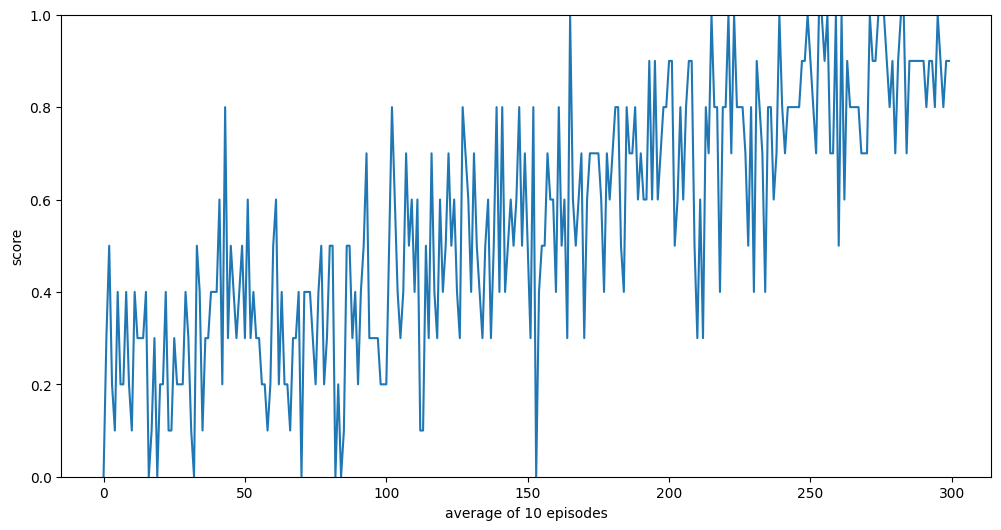

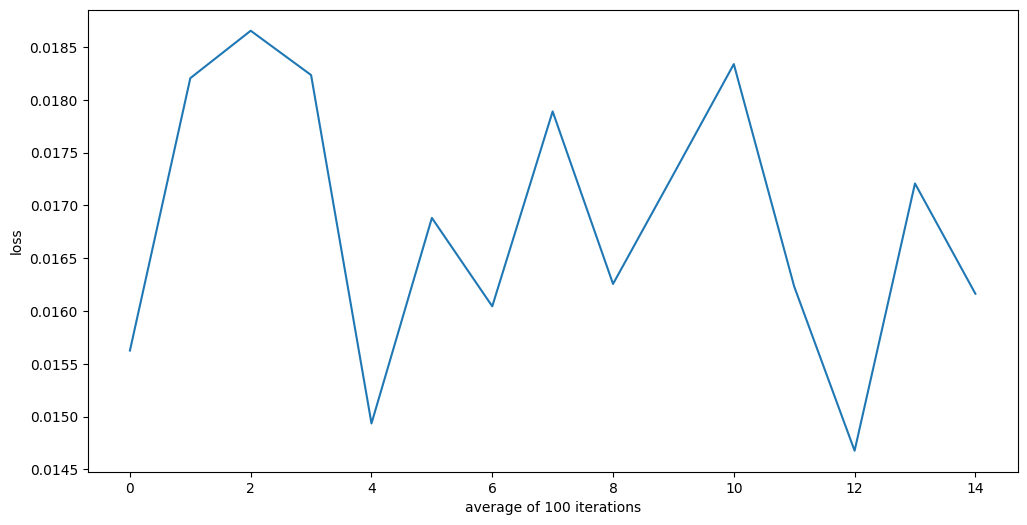

In [38]:
# average reward across 10 episodes
num_episodes = 10
num_samples = rewards.size
num_batches = rewards.size // 10
reward_reshaped = rewards[:num_batches*num_episodes].reshape(num_batches, num_episodes)
average_reward = np.mean(reward_reshaped, axis=1)
plt.figure(figsize=(12,6))
plt.plot(average_reward)
plt.xlabel(f"average of {num_episodes} episodes")
plt.ylabel("score")
plt.ylim(0, 1)
plt.show()


# average loss across 100 iterations
num_iterations = 100
num_samples = loss.size
num_batches = num_samples // num_iterations
loss_episode_reshaped = loss[:num_batches*num_iterations].reshape(num_batches, num_iterations)
average_loss = np.mean(loss_episode_reshaped, axis=1)
plt.figure(figsize=(12,6))
plt.plot(average_loss)
plt.xlabel(f"average of {num_iterations} iterations")
plt.ylabel("loss")
plt.show()
